Целью этой работы было решение задачи, которая может быть поставлена перед компьютерным лингвистом: задачи кластеризации новостей. В результате мы получили опыт предобработки текста и работы с разными алгоритмами кластеризации текстов, получили возможность сравнить их и посмотреть, какой алгоритм наиболее эффективен.

В нашей работе мы опирались в основном на лабораторную работу, разобранную на первом занятии. Кроме того, для получения иерархической и спектральной классификаций была использована документация sklearn:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering  
http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py  
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering  

Для нашей работы в основном нам понадобилась библиотека sklearn, однако для лемматизации текстов использовался pymystem3:  
http://pypi.python.org/pypi/pymystem3/0.1.1  

Кроме того, были использованы:  
http://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure для построения матриц ошибок;  
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html  
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html для удаления дубликатов.  
и  
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html для объяснения сингулярного разложения ниже.

In [1]:
import pandas as pd
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

Для начала нам необходимо прочитать файл и избавиться от новостей-дубликатов. Для этого мы использовали метод .drop_duplicates() библиотеки pandas.

In [15]:
df1 = pd.read_csv('clear1.csv')
texts = df1[['in_out','text']].copy()    

Для нормализации текста нам необходима библиотека Mystem.

In [17]:
from pymystem3 import Mystem
m = Mystem()

Здесь мы нормализуем тексты: приводим к нижнему регистру, находим только символьные токены и лемматизируем с помощью метода .lemmatize() библиотеки Mystem.

In [18]:
import re
def normalize(i):
    i = i.lower()
    string1 = re.findall('\w+', i)
    lemmas = m.lemmatize(' '.join(string1))
    return ''.join(lemmas)

На этом этапе мы записали очищенные тексты в новый файл и затем снова пропустили их через удаление дубликатов, чтобы они пропали наверняка.

In [21]:
for i in texts.text:
    try:
        texts.text = texts.text.replace(i, normalize(i))
    except AttributeError:
        texts.text = texts.text.replace(i, 'n')
        
#Ещё разок избавляемся от дубликатов для верности
#texts = texts.drop_duplicates('text') 
texts.to_csv('norm_raw_texts.csv', encoding='utf-8')

Начинаем работу с алгоритмами и сначала мы работаем с алгоритмом k-средних. Обучаем на всех текстах, кроме первых ста, чтобы у нас оставались тексты для тестирования. Кроме того, для чистоты перемешиваем данные.

In [24]:
dataset = pd.read_csv('norm_raw_texts.csv')
dataset['in_out'] = dataset['in_out'].factorize()[0]
dataset = shuffle(dataset)
labels = dataset.in_out[100:].as_matrix()
true_k = np.unique(labels).shape[0]

SVD: У нас есть большая разреженная матрица, для дальнейшей её обработки мы при помощи svd просто понижаем размерность данных и смотрим на процент приближения. Процент — это сумма дисперсий (коэффициентов на диагонали матрицы в разложении) после того как мы оставили только первые n_components относительно суммы дисперсий в правильном разложении (относительно идеального варианта). Чем больше процент — тем точнее первая матрица приближает вторую.

In [49]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.7, min_df=0.3, ngram_range=(1,3), analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=200)),
    ('norm', Normalizer() ),
    ('clust', KMeans(n_clusters=2))
])
#x = v.fit_transform(df['Review'].values.astype('U'))  ## Even astype(str) would work
#добавлено чтобы избежать ошибок с nan
pipeline.fit_transform(dataset.text[100:].astype(str))
dataset.text.fillna(' ')
dataset.in_out.fillna(' ')
#Кто-нибудь, опишите, что показывает этот параметр и почему он такой, а не другой
#Описывать это нужно для каждого применяемого алгоритма
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

C:\Users\Asus\Anaconda3\envs\mllecture\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Explained variance of the SVD step: 89%


In [50]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = dataset.in_out[100:].as_matrix()

print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

Homogeneity: 0.0801349804835322
Completeness: 0.12709800429741175
V-measure 0.0982951252150815
Adjusted Rand-Index: 0.09932481949604371


Ниже будут представлены данные при значениях max_df = 0.5, min_df = 0.1 на символьных н-граммах. Кроме этого, мы проводили тесты с различными значениями, и все они показали себя несколько хуже, чем эти значения. Например, при соответствующих значениях max/min_df 0.7 и 0.3 качество в среднем падает на 3-4% (до ~88%). При max/min_df соответственно 0.5 и 0.3 качество падает на 1-2% (до ~92%). При кластеризации по словарным н-граммам качество при тех же показателях также падает на 3-4% (возможно, из-за увеличивающейся размерности). В целом колебание качества при именениях max/min_df редко превышает 10%.
Также качество довольно резко падает при переходе с триграмм на биграммы (~10% падения), однако при этом повышается объяснённая дисперсия (до 96%).

In [39]:
#на первых десяти текстах (можно взять больше) посмотрим, как кластеризуются данные
cluster = pipeline.predict(dataset.text[:100])
output = dataset.text[:100]
#Я капитан Шепард и это самый отстойный цикл на Цитадели
#При помощи него мы понимаем, куда какой текст кластеризовался.
#Отвечая на вопрос в третьем задании о том, можно ли при помощи кластеров опознать тему документа, 
#можно опираться на вот эти вот восхитительные результаты
for i in range(len(cluster)):
    print("Кластер {}:".format(cluster[i]), output.values[i][:200])

ValueError: np.nan is an invalid document, expected byte or unicode string.

Мы визуализируем матрицу ошибок с помощью библиотеки %ИМЯБИБЛИОТЕКИ%. На осях расположены номера кластеров от 0 до 27 (от 1 до 28). В местах с кординатами (x,y) отмечено количество текстов кластера x, перепутанных с текстами кластера y.
Похоже, что наш алгоритм работает достаточно хорошо, т.к. чем более светлая ячейка, тем больше ошибок.
Например, мы можем видеть, что события кластера 18 (по вертикали) были распределены почти в каждый из других кластеров, но при этом это было сделано с небольшим количеством текстов.

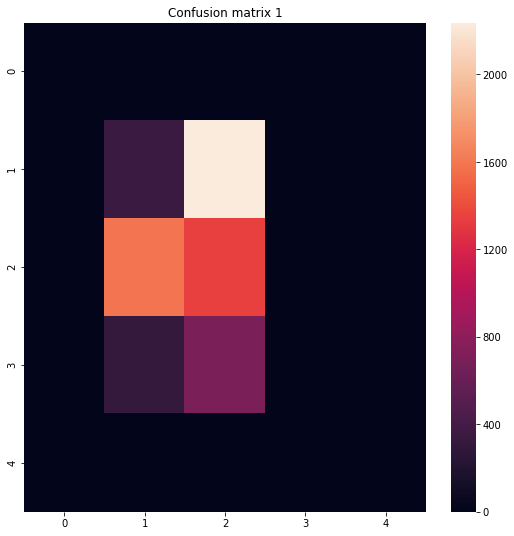

In [51]:
plt.figure(figsize=(9, 9))
sns.heatmap(confusion_matrix(labels, clust_labels))
plt.title("Confusion matrix 1")
plt.show()

In [43]:
dataset

,Unnamed: 0,in_out,text
2671,2671,0,я иметь опыт работа преподаватель правда частн...
5037,5037,1,я бы хотеть помогать ребенок хотеть бы чтобы с...
6595,6595,0,я считать что результат учеба т е отметка учен...
1737,1737,1,я часто сталкиваться с ученик в который я виде...
4848,4848,0,я знать как это происходить я знать как это бы...
2419,2419,0,помогать ребенок в обучение и зарождение желан...
6173,6173,1,хотеться бы снова попробовать себя в роль преп...
1338,1338,0,я мечтать становиться учитель еще в школа пото...
1461,1461,2,я быть такой же ребенок учиться в обычный дере...
1826,1826,1,я очень интересный данный программа я казаться...


На данном этапе мы модифицируем наш конвейер и используем алгоритм спектральной кластеризации. Результат примерно совпадает с результатом для k-means; результат для слов несколько хуже, чем для символьных н-граммов (результат в ячейке ниже). Показатели для слов при тех же df:  
Homogeneity: 0.85933986947  
Completeness: 0.830456881204  
V-measure: 0.844651532925  
Adjusted Rand-Index: 0.715592942238  

In [41]:
pipeline2 = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.1, ngram_range=(1,3), analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=200)),
    ('norm', Normalizer() ),
    ('clust', SpectralClustering(n_clusters=true_k, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=1))
])
pipeline2.fit_transform(dataset.text[100:].astype(str))
labels = dataset.in_out[100:].as_matrix()

explained_variance = pipeline2.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

C:\Users\Asus\Anaconda3\envs\mllecture\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\Asus\Anaconda3\envs\mllecture\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


AttributeError: 'SpectralClustering' object has no attribute 'transform'

In [44]:
clust_labels = pipeline2.named_steps['clust'].labels_
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure:",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

Homogeneity: 0.05495123854528041
Completeness: 0.036461176596642005
V-measure: 0.04383620779941105
Adjusted Rand-Index: 0.052960554605962336


Представим матрицу ошибок для наших кластеров. Из неё видно, что матрица работает практически безошибочно.

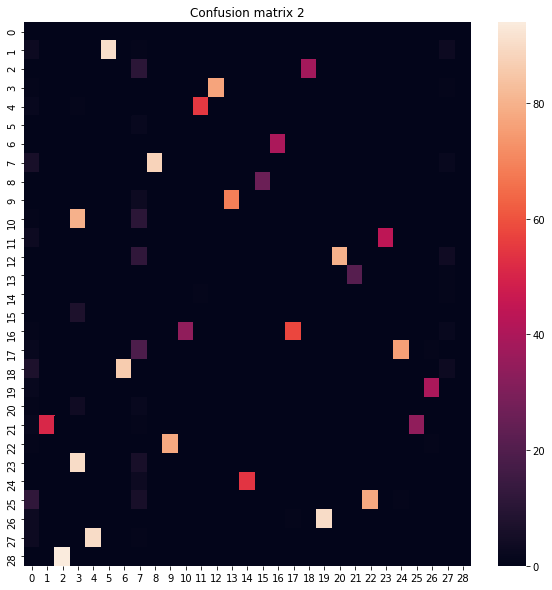

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(labels, clust_labels))
plt.title("Confusion matrix 2")
plt.show()

Модифицируем наш конвейер ещё раз, чтобы попробовать иерархическую кластеризацию. 

In [26]:
pipeline3 = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.1, ngram_range=(1,3), analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=200)),
    ('norm', Normalizer() ),
    ('clust', AgglomerativeClustering(n_clusters=true_k, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', pooling_func=np.mean))
])
pipeline3.fit(dataset.text[100:])

clust_labels = pipeline3.named_steps['clust'].labels_
labels = dataset.event_id[100:].as_matrix()

explained_variance = pipeline3.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 76%


В итоге иерархическая даёт наибольший результат в нашей работе. В выдаче ниже видно результаты для символьных н-граммов; результаты для слов на тех же показателях df:  
Homogeneity: 0.918367536954  
Completeness: 0.886302496614  
V-measure 0.902050153958  
Adjusted Rand-Index: 0.818080995473

In [27]:
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

Homogeneity: 0.928424782414
Completeness: 0.911908553952
V-measure 0.920092555033
Adjusted Rand-Index: 0.842408481133


Из последней матрицы ошибок видно, что иерархическая кластеризация ошибается реже спектральной, хотя тоже иногда путает категории.

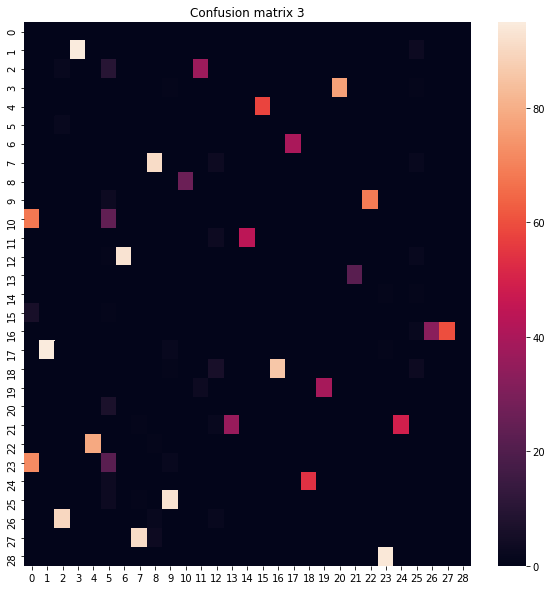

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(labels, clust_labels))
plt.title("Confusion matrix 3")
plt.show()

Теперь посмотрим, как работает алгоритм k-средних с пятью кластерами.

In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, min_df=0.1, ngram_range=(1,3), analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=200)),
    ('norm', Normalizer() ),
    ('clust', KMeans(n_clusters=5))
])

pipeline.fit(dataset.text[100:])


explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 76%


In [9]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = dataset.event_id[100:].as_matrix()

print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

Homogeneity: 0.444641019001
Completeness: 0.968307670752
V-measure 0.609433750217
Adjusted Rand-Index: 0.21491464097


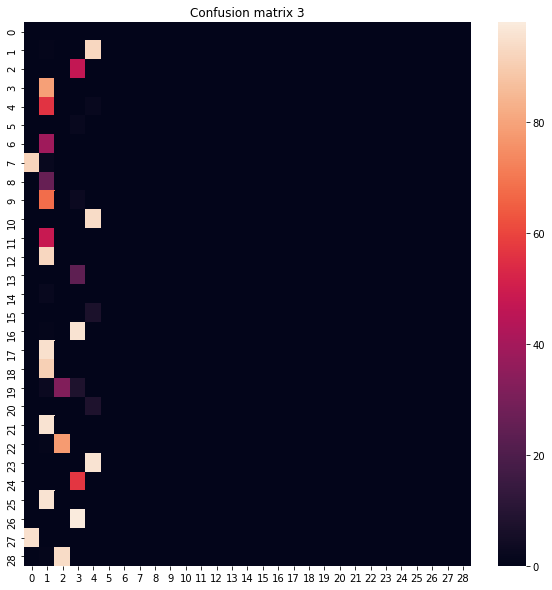

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(labels, clust_labels))
plt.title("Confusion matrix 3")
plt.show()

При сокращении количества кластеров при обучении качество кластеризации резко падает, так что можно сделать вывод, что такого количества данных недостаточно для качественной кластеризации.